In [3]:
import mne
import mne_connectivity
from mne_connectivity import spectral_connectivity_time
from connection_complexity.data.raw_data.EDF.edf_helpers import read_edf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import numpy as np

def describe_2d_array(arr):
    # Ensure the input is a 2D NumPy array
    if len(arr.shape) != 2:
        raise ValueError("Input must be a 2D NumPy array.")

    # Initialize the description dictionary
    description = {}

    # Iterate over the columns
    for i in range(arr.shape[1]):
        column = arr[:, i]
        description[f'Column {i}'] = {
            'count': len(column),
            'mean': np.mean(column),
            'std': np.std(column),
            'min': np.min(column),
            '25%': np.percentile(column, 25),
            '50%': np.percentile(column, 50),
            '75%': np.percentile(column, 75),
            'max': np.max(column)
        }
    
    for col, stats in description.items():
        print(col)
        for stat_name, value in stats.items():
            print(f"{stat_name:6}: {value:.6f}")
        print()


In [5]:
eeg = read_edf('/media/dan/Data/data/iEEG/raw_ieeg/patientDumps/PC/OvertNaming.EDF', preload=True)

# # set bads
# bads = ["TO'7"] # for patient PC
# eeg.info['bads'] = bads
# # remove 60hz + harmonics
# eeg = eeg.notch_filter(np.arange(60, 241, 60),verbose=False)
# eeg,_ = mne.set_eeg_reference(eeg, 'average', projection=False) # false applies it to the data; true makes a new channel

In [6]:
data = eeg.get_data()


In [10]:
wave = data[0,:]
u = np.unique(wave)
print(len(u))

3945


In [9]:
picks=["SP1","SP2","TO1","TO2","TO'1","TO'2"]
data = eeg.get_data(picks=picks) * 1e6 # convert to microvolts because mne does this automatically....

In [10]:
data.shape

(6, 331008)

In [11]:
mean = np.mean(data, axis=1)
std = np.std(data, axis=1)
data = (data - mean[:, None]) / std[:, None]

(512, 6)


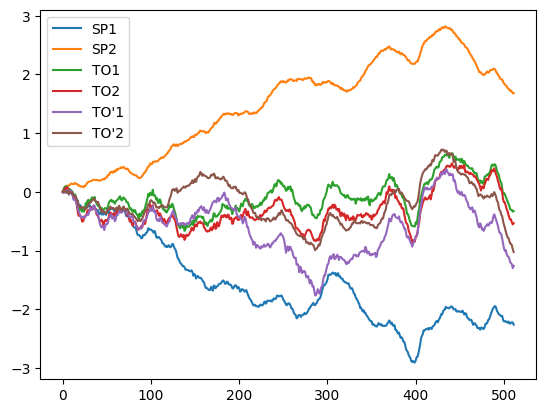

In [18]:
test_start = 264806
context = 512
a = test_start
b = a+context
# subtract the first sample from the rest
test_samples = data[:,a:b] - data[:,a][:,None]
print(test_samples.T.shape)
plt.plot(test_samples.T, label=picks);
plt.legend()

In [29]:
test_samples_fft.shape

(6, 255)

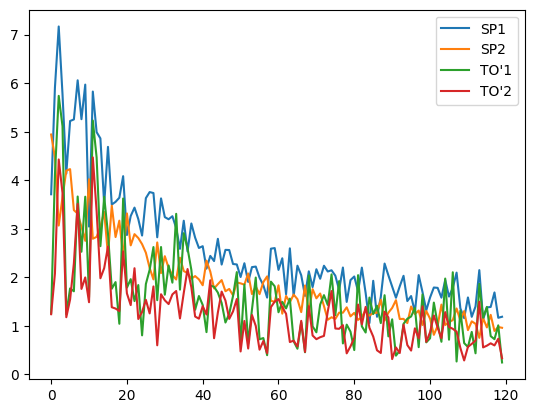

In [30]:
# take the fft of each channel for the test samples. Plot the power spectrum for each channel labeled
# correct 1/f for each channel to better see the differences
test_samples_fft = np.fft.fft(test_samples, axis=1)
test_samples_fft = np.abs(test_samples_fft)
# test_samples_fft = np.log(test_samples_fft)
test_samples_fft = test_samples_fft[:,1:context//2]
# plt.plot(test_samples_fft.T, label=picks);
plt.plot(test_samples_fft.T[30:150,0], label=picks[0]);
plt.plot(test_samples_fft.T[30:150,1], label=picks[1]);
plt.plot(test_samples_fft.T[30:150,-2], label=picks[-2]);
plt.plot(test_samples_fft.T[30:150,-1], label=picks[-1]);
plt.legend()

In [15]:
data[:,a]

array([ 2.08893975, -1.09665198,  0.90601269,  1.05841289,  1.06425371,
        0.48447352])

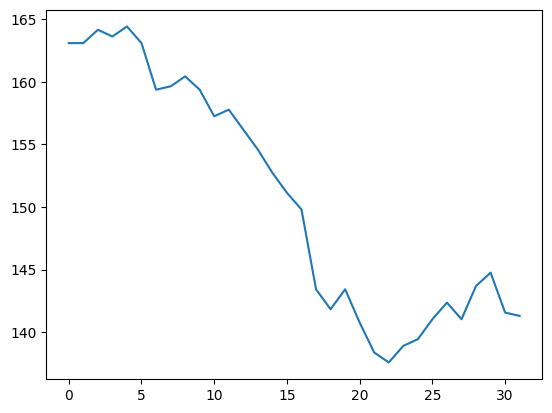

In [52]:
short_array = np.array([163.09448, 163.09448, 164.15785, 163.62617, 164.42369, 163.09448,
       159.37268, 159.63853, 160.43605, 159.37268, 157.24594, 157.77763,
       156.18257, 154.58752, 152.72662, 151.13156, 149.80235, 143.42212,
       141.82707, 143.42212, 140.7637 , 138.37111, 137.5736 , 138.9028 ,
       139.43448, 141.02954, 142.35875, 141.02954, 143.68797, 144.75134,
       141.56123, 141.29538], dtype=np.float32)
plt.plot(short_array)

In [53]:
long_array = data[0,:]

# Function to find the best match index
def find_best_match_index(short_array, long_array):
    min_distance = np.inf
    best_index = -1
    short_length = len(short_array)

    for i in range(len(long_array) - short_length + 1):
        # Extract the subarray from the long array
        sub_array = long_array[i:i + short_length]
        # Calculate the Euclidean distance
        distance = np.linalg.norm(sub_array - short_array)
        # Update the minimum distance and index if a new minimum is found
        if distance < min_distance:
            min_distance = distance
            best_index = i

    return best_index, min_distance

# Finding the best match index
best_match_index, min_distance = find_best_match_index(short_array, long_array)
best_match_index, min_distance

(264807, 2.617855217204995e-05)

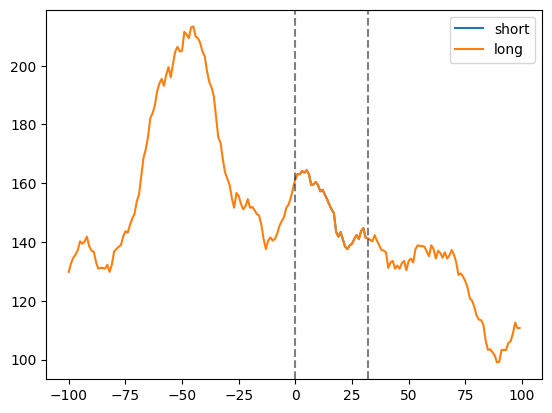

In [51]:
# plot the best match vs the original.  Expand the best match by N samples on either side. Place a vertical line at the best match index start and end
N = 100
long = long_array[best_match_index-N:best_match_index+N]
time_total = np.arange(0, len(long))
time_total = time_total - N
time_short = np.arange(0, len(short_array))
plt.plot(time_short,short_array, label='short')
# place on different axis
# plt.twinx()
plt.plot(time_total,long_array[best_match_index-N:best_match_index+N], label='long')
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axvline(len(short_array), color='k', linestyle='--', alpha=0.5)
plt.legend()
